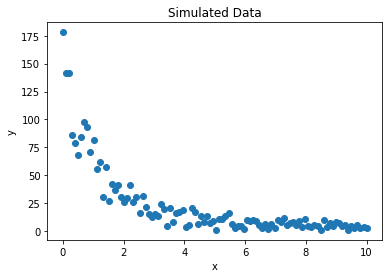

In [7]:
import numpy as np
import matplotlib.pylab as plt
import math
import quadprog
from scipy.sparse import diags

#Generate our data
size = 100
x = np.linspace(0, 10, size) 
y = 100*np.exp(-x) + (100 * np.random.random(size))/(1+x)

#Plot our data
plt.scatter(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Simulated Data')
plt.show()

Default model mse 136.61834716019357


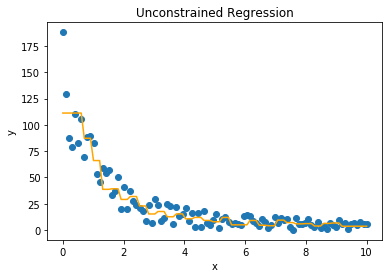

In [8]:
#We can use gradient boosting to regress on this data
import lightgbm as lgb
from sklearn.metrics import mean_squared_error as mse

overfit_model = lgb.LGBMRegressor(silent=True, min_child_samples=5)
overfit_model.fit(x.reshape(-1,1), y)
 
#predicted output from the model from the same input
prediction = overfit_model.predict(x.reshape(-1,1))

size = 100
x_test = np.linspace(0, 10, size) 
y_test = 100*np.exp(-x) + (100 * np.random.random(size))/(1+x)
 
print ("Default model mse", mse(y_test, overfit_model.predict(x_test.reshape(-1,1))))

overfit_y = overfit_model.predict(x_test.reshape(-1,1))

plt.scatter(x_test,y_test)
plt.plot(x,overfit_y, color = 'orange')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Unconstrained Regression')
plt.show()

Monotone model mse 134.36501392675734


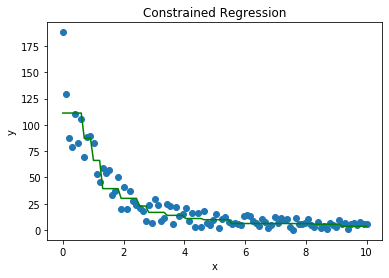

In [9]:
#If we know that our data should be montonically decreasing then we can include that information

monotone_model = lgb.LGBMRegressor(silent=True, min_child_samples=5, monotone_constraints="-1")
monotone_model.fit(x.reshape(-1,1), y)

print ("Monotone model mse", mse(y_test, monotone_model.predict(x_test.reshape(-1,1))))
monotone_y = monotone_model.predict(x_test.reshape(-1,1))
plt.scatter(x_test,y_test)
plt.plot(x,monotone_y, color = 'green')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Constrained Regression')
plt.show()
#We see a small increase in accuracy but this is also an easier object to optimise.

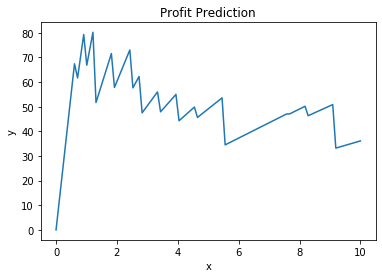

In [10]:
#If we take this as the regression for our volume sold then we can use this to make an objective function

#We make an objective function class, in theory this can help us avoid technical debt.
class Objective(lgb.LGBMRegressor):
    Unit_Cost = 0
    epsilon = 0.1

    #Expected profit from volume prediction
    def Profit(self,x):
        return (x-self.Unit_Cost)*self.predict(x.reshape(-1,1))

    #As it stands no natural derivative but we can use finite difference approximations
    def Forward_Deriv_1(self,x):
        return (self.Profit(x+self.epsilon)-self.Profit(x))/self.epsilon

    def Forward_Deriv_2(self,x):
        return (self.Profit(x+1)-self.Profit(x))

    def Backward_Deriv_1(self,x):
        return (self.Profit(x)-self.Profit(x-self.epsilon))/self.epsilon

    def Backward_Deriv_2(self,x):
        return (self.Profit(x)-self.Profit(x-self.epsilon))

    def Central_Deriv_1(self,x):
        return (self.Profit(x+self.epsilon)-self.Profit(x-self.epsilon))/(2*self.epsilon)
    
    def Central_Deriv_2(self,x):
        return (self.Profit(x+1)-self.Profit(x-1))/2
    
#We make an objective function out of our regression
monotone_obj = Objective(min_child_samples=5,monotone_constraints="-1")
monotone_obj.fit(x.reshape(-1,1), y)

#This has a problem
profit = monotone_obj.Profit(x)
plt.plot(x,profit)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Profit Prediction')
plt.show()
#The step function like output of decision tree based method results in extremely non-convex predictions.

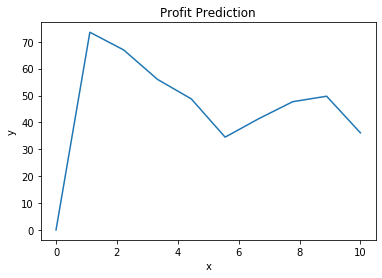

In [11]:
#If once restricted to integer values the objective was convex then we wouldn't have an issue.
x_test = np.linspace(0, 10, 10)
profit = monotone_obj.Profit(x_test)
plt.plot(x_test,profit)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Profit Prediction')
plt.show()
#However even with our relatively nice data, this doesn't occur.
#If we could transform every volume observation deterministically into a profit prediction a convex regressor
#could use that but there are reasons to believe that this might be extremely difficult for decision tree
#based methods (the step function nature just doesn't work with convexity constraints)

In [71]:
#A broad class of regressors that respond to constraints is the use of Bernstein basis functions
#The univeriate case is well established, the montonic case is established in the multivariate case.
class Regressor():
    
    def __init__(self,weights):
        self.weights = weights
        self.num_of_bases = len(weights)

    def fit(self,X,y):
        pass

#n choose k function
def nCk(n,r):
    f = math.factorial
    return f(n) // f(r) // f(n-r)

#Bernstein polynomial function
def Bernstein_Polynomial(x,v,n):
    return nCk(n,v) * x**v * (1-x)**(n-v)

def Bernstein_Base_Evaluations(x,n):
    output = np.zeros((np.size(x),n+1)) #preallocate for speed.
    for v in range(n+1):
        output[:,v] = Bernstein_Polynomial(x,v,n)
    return output

def quadprog_solve_qp(P, q, G=None, h=None, A=None, b=None):
    qp_G = .5 * (P+P.T)
    qp_a = -q
    if A is not None:
        qp_C = -np.vstack([A, G]).T
        qp_b = -1*np.hstack([b, h])
        meq = A.shape[0]
        return quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)[0]
    else:
        qp_C = -G.T
        qp_b = -1*h
        meq = 0
        return quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)[0]

def Build_Monotonic_Increasing_Constraints(n):
    diagonals = [[1]*n, [-1]*(n-1)]
    G = diags(diagonals, [0,1])
    G = G.todense()
    G = G[0:(n-1),:]
    v = np.zeros((1,n))
    v[0,0] = -1
    G = np.concatenate((v,G), axis = 0)
    h = np.array([0.]*n)

    return G,h

def Build_Monotonic_Decreasing_Constraints(n):
    diagonals = [[-1]*n, [1]*(n-1)]
    G = diags(diagonals, [0,1])
    G = G.todense()
    G = G[0:(n-1),:]
    v = np.zeros((1,n))
    v[0,0] = -1
    G = np.concatenate((v,G), axis = 0)
    h = np.array([0.]*n)

    return G,h

def Build_Convex_Constraints(n):
    diagonals = [[2]*n, [-1]*(n-1), [-1]*(n-1)]
    G = diags(diagonals, [0,1,-1])
    G = G.todense()
    G = G[:(n-1),:]
    G = G[1:,:]
    v = -np.eye(n)
    v[0,0] = -1
    G = np.concatenate((v,G), axis = 0)
    h = np.array([0.]*(2*n-2))

    return G,h

def Build_Concave_Constraints(n):
    diagonals = [[-2]*n, [1]*(n-1), [1]*(n-1)]
    G = diags(diagonals, [0,1,-1])
    G = G.todense()
    G = G[:(n-1),:]
    G = G[1:,:]
    v = -np.eye(n)
    v[0,0] = -1
    G = np.concatenate((v,G), axis = 0)
    h = np.array([0.]*(2*n-2))
    
    return G,h

class Bernstein_Regressor(Regressor):
    
    def __init__(self, weights, constraints = None):
        super().__init__(weights)
        self.constraints = constraints

    def evaluate(self,x):
        n = self.num_of_bases - 1
        return np.dot(Bernstein_Base_Evaluations(x,n),self.weights)
        
    def fit(self,x,y):
        X = Bernstein_Base_Evaluations(x,self.num_of_bases - 1)
        P = np.dot(X.T,X)
        q = -1*np.dot(X.T,y)
        if self.constraints == None:
            G = np.zeros((1, self.num_of_bases))
            h = np.array([1.])
        elif self.constraints == -1:#monotonically decreasing
            G,h = Build_Monotonic_Decreasing_Constraints(self.num_of_bases)
        elif self.constraints == 1:#monotonically increasing
            G,h = Build_Monotonic_Increasing_Constraints(self.num_of_bases)
        elif self.constraints == 2:#concave
            G,h = Build_Concave_Constraints(self.num_of_bases)
        elif self.constraints == -2:#convex
            G,h = Build_Convex_Constraints(self.num_of_bases)

        self.weights = quadprog_solve_qp(P, q, G, h)


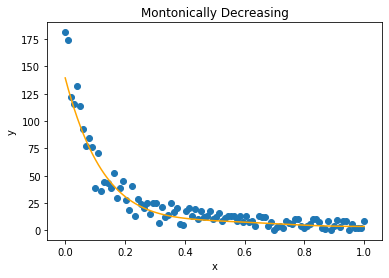

In [39]:
#Now for some examples

#This is a montonically decreasing restriction

#We have to first confine x to [0,1]
x_train = x/10
y_train1 = 100*np.exp(-x) + (100 * np.random.random(size))/(1+x)
y_test1 = 100*np.exp(-x) + (100 * np.random.random(size))/(1+x)

#Have to make model. I'll probably redo how this model is initialised in future
number_of_basis_functions = 9
n = number_of_basis_functions
weights = np.linspace(0,1,n)
model = Bernstein_Regressor(weights,-1)
model.fit(x_train,y_train1)
y_pred1 = model.evaluate(x_test)

plt.scatter(x_train,y_test1)
plt.plot(x_train,y_pred1, color = 'orange')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Montonically Decreasing')
plt.show()

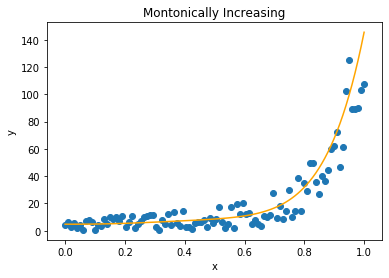

In [38]:
#Now for some examples

#This is a montonically increasing restriction

y_train2 = y_train1[::-1]
y_test2 = y_test1[::-1]

#Have to make model. I'll probably redo how this model is initialised in future
number_of_basis_functions = 9
n = number_of_basis_functions
weights = np.linspace(0,1,n)
model = Bernstein_Regressor(weights,1)
model.fit(x_train,y_train2)
y_pred2 = model.evaluate(x_test)

plt.scatter(x_train,y_test2)
plt.plot(x_train,y_pred2, color = 'orange')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Montonically Increasing')
plt.show()

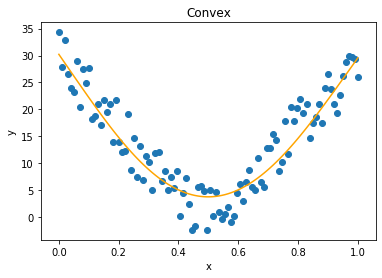

In [45]:
#Now for some examples

#This is convex restriction

y_train3 = (x-5)**2 + 3*np.sin(x) + (10*np.random.random(size))
y_test3 = (x-5)**2 + 3*np.sin(x) + (10*np.random.random(size))

#Have to make model. I'll probably redo how this model is initialised in future
number_of_basis_functions = 9
n = number_of_basis_functions
weights = np.linspace(0,1,n)
model = Bernstein_Regressor(weights,-2)
model.fit(x_train,y_train3)
y_pred3 = model.evaluate(x_test)

plt.scatter(x_train,y_test3)
plt.plot(x_train,y_pred3, color = 'orange')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Convex')
plt.show()

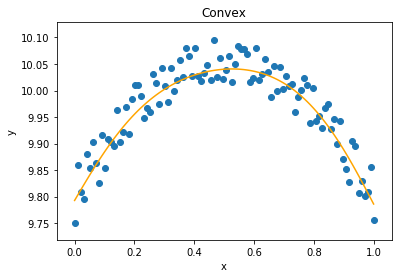

In [75]:
#This is concave restriction

#Current implementation is having trouble with negative evaluations
y_train4 = -(0.1*x-0.5)**2 +10 + 0.1*np.random.random(size)
y_test4 = -(0.1*x-0.5)**2 +10 + 0.1*np.random.random(size)

#Have to make model. I'll probably redo how this model is initialised in future
number_of_basis_functions = 9
n = number_of_basis_functions
weights = np.linspace(0,1,n)
model = Bernstein_Regressor(weights,2)
model.fit(x_train,y_train4)
y_pred4 = model.evaluate(x_test)

plt.scatter(x_train,y_test4)
plt.plot(x_train,y_pred4, color = 'orange')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Convex')
plt.show()